# Изучение поведения пользователей в старт-апе "AAA"

# Описание проекта 

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

План работы:

1. Выгрузка и анализ данных.
2. Преобработка данных (работа с дубликатами, пропусками и т д.)
- Приведение названия колонок к нужному формату
- Проверка на наличие пропусков и дубликатов
- Добавление нужных столбцов и преобразование типа данных со временем и датой
3. Изучение и проверка данных 
- Изучение количества событий и пользователей в логе
- Построение Гистограмм по дате и времени
4. Воронка событий 
- Определение доли пользователей, совершивших хотя бы 1 покупку
- Определение последовательности событий воронки 
- Нахождение общей конверии и конверсии шага
5. Результаты эксперимента
- Построение функции для проверки гипотезы
- Проверяем находят ли статистические критерии разницу между выборками 246 и 247
- Проверяем находят ли статистические критерии разницу между выборками 246 и 248
- Проверяем находят ли статистические критерии разницу между выборками 247 и 248
- Проверяем находят ли статистические критерии разницу между выборками 240 и 248
- Выводы

## Выгрузка данных

In [62]:
import pandas as pd
import datetime as dt
import seaborn 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from pandas.plotting import register_matplotlib_converters
import warnings

In [63]:
register_matplotlib_converters()

In [64]:
#Импорт данных 
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


По предварительному взгляду на даннные, мы видим, что в таблице нет пропусков.
Необходимо преобразовать названия столбцов и проверить данные на дубликаты, а также преобразовать тип данных столбца EventTimestamp.

## Предобработка данных 

### Приведение названия колонок к нужному формату

In [66]:
#Приведение названия колонок к нижнему регистру и корректному написанию
data.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time','ExpId':'group'}, inplace = True )
data.head(5)

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверка на наличие пропусков и дубликатов. 

In [67]:
# Поиск и удаление дубликатов 
data.duplicated().sum()

413

In [68]:
data_d = data.drop_duplicates(keep = False)

In [69]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243358 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243358 non-null  object
 1   user_id     243358 non-null  int64 
 2   event_time  243358 non-null  int64 
 3   group       243358 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [70]:
# проверка на наличие пропусков
data_d.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

### Добавление нужных столбцов и преобразование типа данных со временем и датой

In [71]:
# Добавляю столбцы с датой и временем и только с датой
data_d['date_time'] = pd.to_datetime(data_d['event_time'], unit = 's')
data_d['date'] = data_d['date_time'].astype('datetime64[D]')
data_d.head(5)

/tmp/ipykernel_30/859165467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_d['date_time'] = pd.to_datetime(data_d['event_time'], unit = 's')
/tmp/ipykernel_30/859165467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_d['date'] = data_d['date_time'].astype('datetime64[D]')


,event_name,user_id,event_time,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [72]:
data_d.info() # провекра типа данных в таблице 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243358 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243358 non-null  object        
 1   user_id     243358 non-null  int64         
 2   event_time  243358 non-null  int64         
 3   group       243358 non-null  int64         
 4   date_time   243358 non-null  datetime64[ns]
 5   date        243358 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


## Изучение и проверка данных

### Изучение количества пользователей и событий в логе

In [73]:
# количество событий в логе
data_event_old = data_d['event_name'].count()
data_event_old

243358

In [74]:
#количество уникальных значений в каждом столбце 
data_d.nunique() 

event_name         5
user_id         7550
event_time    176459
group              3
date_time     176459
date              14
dtype: int64

In [75]:
# количество пользоваталей в логе
data_user_old = data_d['user_id'].nunique()
data_user_old

7550

In [76]:
# количество событий на пользователя
data_d['event_name'].count() / data_d['user_id'].nunique()

32.23284768211921

In [77]:
# максимальная дата в логе 
data_d['date'].max()

Timestamp('2019-08-07 00:00:00')

In [78]:
# минимальная дата в логе 
data_d['date'].min()

Timestamp('2019-07-25 00:00:00')

### Построение Гистограмм по дате и времени

Гистограмма по дате и времени


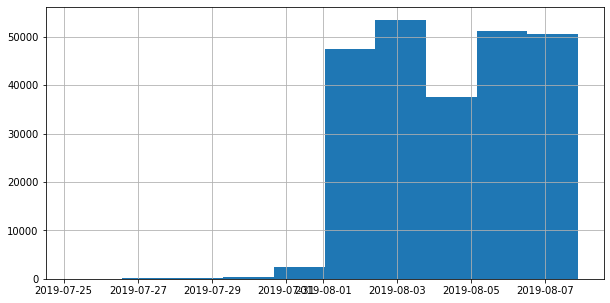

In [79]:
# Построение исходной гистограмы по дате и времени 
period_old = data_d['date_time'].hist(figsize=(10,5))
print('Гистограмма по дате и времени')
period_old;

In [80]:
data_new = data_d[(data_d['date_time'] > '2019-08-01')]

Гистограмма по дате и времени


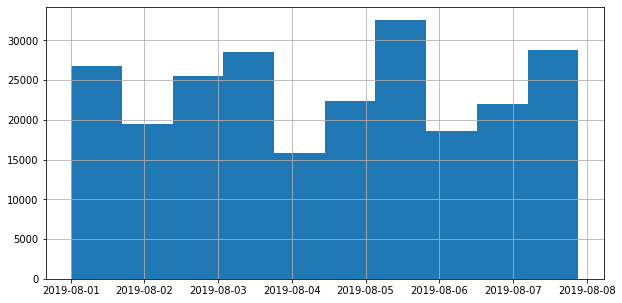

In [81]:
# Построение гистограммы по дате и времени после отсечения данных
period_new= data_new['date_time'].hist(figsize=(10,5))
print('Гистограмма по дате и времени')
period_new;

Мы "отрезали" данные до 1 августа 2019 года, так как их было незначительное количество, которое не влияло на проведение исследования

In [82]:
# количество событий в логе
data_event_new = data_new['event_name'].count()
data_event_new

240534

In [83]:
# количество уникальных пользователей в логе
data_user_new = data_new['user_id'].nunique()
data_user_new

7533

In [84]:
# изменение в количестве событий после отрезаниия данных по дате
event_change = data_event_old - data_event_new
event_change

2824

In [85]:
event_change_pr = (event_change / data_event_old *100).round(2)
event_change_pr

1.16

In [86]:
# изменение в количестве пользователей после отрезаниия данных по дате
users_change = data_user_old - data_user_new
users_change

17

In [87]:
users_change_pr = (users_change / data_user_old *100)
users_change_pr

0.2251655629139073

In [88]:
# Проверяем, что у вас есть пользователи из всех трёх экспериментальных групп.
data_d['group'].unique()

array([246, 248, 247])

In [89]:
users = data_d.groupby(['group']).agg({'user_id':'sum'})
users

,user_id
group,
246,3.641560e+23
247,3.646191e+23
248,3.975487e+23


Мы изучили данные, узнали о количестве событий и пользователей в логе.
Также убрали устаревшие  и неактуальные данные для исследования.
В результате чего в логе стало на 0% пользователей меньше и на 1052 (0,43%) событий меньше, что не повлияет критически на наше исследование.

## Воронка событий

### Определение доли пользователей, совершивших хоть 1 покупку 

In [90]:
# события в логе и как часто они встречаются
data_new['event_name'].value_counts()

MainScreenAppear           117226
OffersScreenAppear          46317
CartScreenAppear            42241
PaymentScreenSuccessful     33765
Tutorial                      985
Name: event_name, dtype: int64

In [91]:
# Доля пользователей, совершивших хоть 1 покупку
table_a = data_d.groupby('event_name')['user_id'].nunique().reset_index()
table_a['perc'] = table_a['user_id'] / (data_d['user_id'].nunique())
table_a['perc'] = (table_a['perc'] *100).round(2)# деление на общее число пользователей
table_a = table_a.sort_values(by='user_id', ascending=False)
table_a

,event_name,user_id,perc
1,MainScreenAppear,7438,98.52
2,OffersScreenAppear,4613,61.10
0,CartScreenAppear,3749,49.66
3,PaymentScreenSuccessful,3544,46.94
4,Tutorial,847,11.22


### Определение последовательности событий воронки

Cобытийной аналитике воронка — это несколько заранее обозначенных последовательных действий на сайте, в игре или приложении, которые пользователи должны выполнить для достижения результата. 

Сформулируем воронку покупки продуктов питания:

Главный экран приложения =>
Экран с предложениями =>
Экран с корзиной =>
Экран с оплатой.

А вот шаг tutorial - руководство - лишний. Его надо удалить.

In [92]:
# Убираем лишний степ, не входящий в воронку по продажам
data_filtered = data_new[(data_new['event_name'] != 'Tutorial')]
data_filtered['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

### Нахождение общей конверии и конверсии шага

In [93]:
# Рассчитаем воронку
# Уникальные пользователи 


In [94]:
funnel = (data_filtered.groupby('event_name')
                    .agg(users=('user_id','nunique'))
                    .sort_values(by='users', ascending = False)
                    .reset_index()
         )
funnel

,event_name,users
0,MainScreenAppear,7418
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3536


In [95]:
# Конверсия 
funnel['conversion'] = (funnel['users'] / funnel['users'].max()*100).round(2)
funnel

,event_name,users,conversion
0,MainScreenAppear,7418,100.00
1,OffersScreenAppear,4593,61.92
2,CartScreenAppear,3734,50.34
3,PaymentScreenSuccessful,3536,47.67


In [96]:
# Конверсия шага
funnel['conversion_step'] = (funnel['conversion'] / funnel['conversion'].shift(1, fill_value=100) *100).round(2)
funnel

,event_name,users,conversion,conversion_step
0,MainScreenAppear,7418,100.00,100.00
1,OffersScreenAppear,4593,61.92,61.92
2,CartScreenAppear,3734,50.34,81.30
3,PaymentScreenSuccessful,3536,47.67,94.70


Мы рассчитали общую конверсию, поделив количество пользователей по событиям на общее количество уникальных пользователей (прошедших шаг 1).
Мы рассчитали конверсию шага и можем увидеть, что больше всего пользователей отваливается на этапе OffersScreenAppear. Возможно после просмотра главной страницы что-то происходит не так в виду технической ошибки \ недостаточной работы над дизайном сайта и т д
47.7% пользователей доходит от первого шага до оплаты товаров. Думаю, этот показатель можно улучшить. 

## Результаты эксперимента

In [97]:
# Колтичество пользоватлей в каждой экспериментальной группе 
group_users = data_filtered.groupby(['group']).agg({'user_id':'nunique'})
group_users

,user_id
group,
246,2482
247,2512
248,2535


In [98]:
pt = data_filtered.pivot_table(index='event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').sort_values(246, ascending=False)
pt[240] = pt[246] + pt[247]
pt

group,246,247,248,240
event_name,,,,
MainScreenAppear,2449,2476,2493,4925
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1199,1156,1181,2355


In [99]:
# проверка есть ли одни и те же пользователи в разных группах
x = data_filtered.groupby(['user_id']).agg({'group':'nunique'}).query('group >1')
x

,group
user_id,


In [100]:
#data_filtered.pivot_table(index='user_id', values='event_name', aggfunc={'count'}).describe()

In [101]:
#seaborn.boxplot(data=data, x="user_id", y="event_name");

In [102]:
#data_filtered.pivot_table(index='user_id', values='event_name', aggfunc={'count'}).median()

### Построение функции для проверки гипотез 

Нулевая гипотеза: различий между группами нет.  Альтернативная гипотеза: различия между группами есть.

Уровень значимости для дальнейших тестирований = 0.05

Создадим функцию для выполнения z-test.

####  Проверяем находят ли статистические критерии разницу между выборками 246 и 247.

In [103]:
alpha = .05 # критический уровень статистической значимости

In [104]:

def ztest(data_a, data_b, event, alpha):
    alpha = alpha
    
    # число пользователей в группе 1 и группе 2:
    trials = np.array([data_a['user_id'].nunique(), data_b['user_id'].nunique()])
    
    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([data_a[data_a['event_name'] == event]['user_id'].nunique(),
                        data_b[data_b['event_name'] == event]['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = success[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = success[1]/trials[1]

    # пропорция в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Действие:', event)
    print('Уровень значимости:', alpha)
    print('p-значение:', p_value.round(3))

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между группами  есть значимая разница')
        print()
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
        print()

In [105]:
#Список уникальных событий для цикла:
events_list = data_filtered['event_name'].unique()

In [106]:
for event in events_list:
    ztest(data_filtered[data_filtered['group'] == 246], data_filtered[data_filtered['group'] == 247], event, alpha)
print()

Действие: MainScreenAppear
Уровень значимости: 0.05
p-значение: 0.754
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: OffersScreenAppear
Уровень значимости: 0.05
p-значение: 0.241
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: CartScreenAppear
Уровень значимости: 0.05
p-значение: 0.223
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: PaymentScreenSuccessful
Уровень значимости: 0.05
p-значение: 0.105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными




У нас подтвердилась 0-гипотезу по всем 4 событиям между группами 246 и 247 - значимых различий в группах нет.

####  Проверяем находят ли статистические критерии разницу между выборками 246 и 248.

Нулевая гипотеза: различий между группами нет.  Альтернативная гипотеза: различия между группами есть.

In [107]:
for event in events_list:
    ztest(data_filtered[data_filtered['group'] == 246], data_filtered[data_filtered['group'] == 248], event, alpha)
print()

Действие: MainScreenAppear
Уровень значимости: 0.05
p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: OffersScreenAppear
Уровень значимости: 0.05
p-значение: 0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: CartScreenAppear
Уровень значимости: 0.05
p-значение: 0.078
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: PaymentScreenSuccessful
Уровень значимости: 0.05
p-значение: 0.223
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными




У нас подтвердилась 0-гипотеза, значимых статистических различий между группами нет.

#### Проверяем находят ли статистические критерии разницу между выборками 247 и 248.

Нулевая гипотеза: различий между группами нет.  Альтернативная гипотеза: различия между группами есть.

In [108]:
for event in events_list:
    ztest(data_filtered[data_filtered['group'] == 247], data_filtered[data_filtered['group'] == 248], event, alpha)
print()

Действие: MainScreenAppear
Уровень значимости: 0.05
p-значение: 0.519
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: OffersScreenAppear
Уровень значимости: 0.05
p-значение: 0.933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: CartScreenAppear
Уровень значимости: 0.05
p-значение: 0.588
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: PaymentScreenSuccessful
Уровень значимости: 0.05
p-значение: 0.685
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными




У нас подтвердилась 0-гипотеза, значимых статистических различий между группами нет.

#### Проверяем находят ли статистические критерии разницу между выборками 240 и 248.

Нулевая гипотеза: различий между группами нет.  Альтернативная гипотеза: различия между группами есть.

In [109]:
combined_group_a = pd.concat([data_filtered[data_filtered['group'] == 246], data_filtered[data_filtered['group'] == 247]])

In [110]:
for event in events_list:
    ztest(combined_group_a, data_filtered[data_filtered['group'] == 248], event, alpha)
print()

Действие: MainScreenAppear
Уровень значимости: 0.05
p-значение: 0.349
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: OffersScreenAppear
Уровень значимости: 0.05
p-значение: 0.44
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: CartScreenAppear
Уровень значимости: 0.05
p-значение: 0.184
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Действие: PaymentScreenSuccessful
Уровень значимости: 0.05
p-значение: 0.64
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными




У нас подтвердилась 0-гипотеза, значимых статистических различий между группами нет.

### Выводы

Мы изучили данные мобильного приложения по продаже продуктов питания. 
Произвели анализ, проверку и предобработку данных для последующего анализа ( удалили дубликаты, преобразовали тип данных, проверили на наличие пропусков).
Далее мы построили воронку событий и нашли лишнее событие. 
Мы рассчитали общую конверсию, поделив количество пользователей по событиям на общее количество уникальных пользователей (прошедших шаг 1). Мы рассчитали конверсию шага и можем увидеть, что больше всего пользователей отваливается на этапе OffersScreenAppear. Возможно после просмотра главной страницы что-то происходит не так в виду технической ошибки \ недостаточной работы над дизайном сайта и т д 47.7% пользователей доходит от первого шага до оплаты товаров. Думаю, этот показатель можно улучшить.
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
Мы произвели тест гипотез для выяснения того, какой шрифт лучше.
При выбранном уровне значимости в 0.05 мы получили результаты, подтверждающие 0-гипотезу о том, что статистически значимых различий между группами нет, с большим отрывом от уровня значимости. 
Мы провели 20 тест проверки гпотез и все они подтвердили что различий между группами нет, а значит измененный шрифт никак не влияет на поведение пользователей.
В связи с этим, счиатем нецелесообразным перепроводить тест по гипотезам с новым уровнем значимости (уточненным:0.05 \ 20 = 0.0025),  так как результат мы получим тот же. 
Мы не рекоммендуем изменять шрифт приложения.
